First, we define dataframe to save all InSAR data of one thaw season into one file. For example, if you have 10 interferograms spanning from June 2022 until August 2022, you save all data into one big file that has these features:

Longitude of pixel, Latitude of pixel, LOS of interferogram-1, LOS of interferogram-2,..., incidence angle

The output will be a "all_data" file that has all data of each pixel.
Data is in "crop_date1_date2.tif.site_name.xyz" and "crop_incidence.tif.xyz" format.

In [1]:
def read_xyz(file): # space-delimeated only
    
    f = open(file,'r')   
    x = []
    y = []
    z = []

    while True:
        line = f.readline().strip()
        if line=='':
            #print ('break')
            break
        raw = line.split(' ')
        x.append(float(raw[0]))	
        y.append(float(raw[1]))
        z.append(float(raw[2]))
    f.close()
    
    return x,y,z


def read_z(file): # space-delimeated only    
    f = open(file,'r')   
    z = []

    while True:
        line = f.readline().strip()
        if line=='':
            #print ('break')
            break
        raw = line.split(' ')

        z.append(float(raw[2]))
    f.close()
    
    return z

def RMSE(obs,exp):
    s=[]
    for i in range(len(obs)):
        ss = (obs[i]-exp[i])**2
        s.append(ss)
        mse = sum(s)/len(obs)
        rmse = math.sqrt(mse)
        
    return(rmse)

from glob import glob
data_files = glob('crop*.xyz') # data that is cropped from original GeoTiff files for each interferogram
data_files = sorted(data_files)
length = len(data_files)
inc = read_xyz(data_files[length-1]) # one is incidence angle data


x = read_xyz(data_files[0])[0]
y = read_xyz(data_files[0])[1]
## makes panda dataframe with x,y, yyyymmdd columns to fill in future!

import pandas as pd
  
list_of_tuples = list(zip(x, y))

df = pd.DataFrame(list_of_tuples, columns=['X', 'Y'])

for i in range(len(data_files)):
    inf_dates = ['%s'%(data_files[i][5:22])] 
    df['%s'%(inf_dates[0])] = read_z(data_files[i])
    
## format of file:
## Longitude, latitude, LOS of each interferogram, incidence angle on that pixel

df.to_csv('all_data') # name of the file
print('data frame size is: ', df.shape) # shape of the file


data frame size is:  (32, 21)


Second, we read temperature file and make ADDT and read "all_data" (output of cell above) to make G matrix which is sqrt of ADDT... 
Look at Equation-4 of paper.

\begin{equation}
d = Gm
\end{equation}

\begin{equation}
\begin{bmatrix} D_{1}\\D_{2}\\ \vdots\\D_{N} \end{bmatrix} = \begin{bmatrix} \sqrt{A_{2,1}} - \sqrt{A_{1,1}}\\\sqrt{A_{2,2}} - \sqrt{A_{1,2}}\\ \vdots\\\sqrt{A_{2,N}} - \sqrt{A_{1,N}} \end{bmatrix} \begin{bmatrix} E\end{bmatrix}
\end{equation}

In [2]:
### estimation of E (seasonal amplitude)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


## read temperature data for whole year for Sagwon station
site_name = 'sagwon.csv'

df_st = pd.read_csv('%s'%(site_name))
heads_st = pd.read_csv('%s'%(site_name)).columns.tolist()

# just a simple plot 
def plot_temp(file,station_name): # x is time, y is temperature
    
    import matplotlib.pyplot as plt
    import pandas as pd
    
    df_st = pd.read_csv(file)
    heads_st = pd.read_csv(file).columns.tolist()
    
    x = df_st['DATE'].tolist()
    tmax = df_st['TMAX'].tolist()
    tmin = df_st['TMIN'].tolist()
    tobs = df_st['TOBS'].tolist()
    
                
    fig = plt.figure(figsize=(8,6))
    
    myticks = ['2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2022-01-01']
    
    plt.plot(x,tmax, color='red', label = 'T-Max')
    plt.plot(x,tmin, color='blue', label = 'T-Min')
    plt.plot(x,tobs, color='green', label = 'T-Obs')
    plt.axhline(y = 0, color = 'black', linestyle = '--', label='T = 0')

    plt.plot()

    plt.ylim(int(min(tmin)-5),int(max(tmax)+5))
    plt.xlabel('Time')
    plt.ylabel('Air Temperature [$^\circ$C]')
    plt.xticks(myticks)
    plt.legend()
    plt.title('%s'%(station_name))
    plt.gca().yaxis.grid(True)
    plt.savefig('ts_temp.png',dpi=300, format='png', bbox_inches='tight')
    plt.show()
    
    return 
    
# calculation of ADDT, better to put beginning and end of thaw season manually from sagwon data

def acc_thaw_days(file,yr,mm3,dd3,mm2,dd2,mm,dd): ## begining of thaw, end of thaw, chosen date
    
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from datetime import datetime, date, time, timedelta
    import matplotlib.dates as dts

    date = '%s-%s-%s'%(yr,mm,dd)    # chosen day: it is interferogram date1 or date 2
    date2 = '%s-%s-%s'%(yr,mm2,dd2) # last day of thaw season
    date1 = '%s-%s-%s'%(yr,mm3,dd3) # first day of thaw season
    
    # read file (csv)
    df_st = pd.read_csv(file)
    heads_st = pd.read_csv(file).columns.tolist()
    
    # save as a list
    x = df_st['DATE'].tolist()
    tmax = df_st['TMAX'].tolist()
    tmin = df_st['TMIN'].tolist()
    tobs = df_st['TAVG'].tolist()
    
    k = []
    for i in range(len(x)):
        if x[i] == date:
            k.append(i)
    
    c = [] #(date,temp) for all data with temp>0
    
    for i in range(len(df_st['TAVG'].tolist())):
        if df_st['TAVG'].tolist()[i] > 0:
            c.append((df_st['DATE'].tolist()[i],(df_st['TAVG'].tolist()[i])))
    
    day_1 = dts.date2num(datetime.strptime('2022-01-01', "%Y-%m-%d")) #first day of year
    doy = [] # from 1 to 365

    for i in range(len(df_st['DATE'].tolist())):
        d = dts.date2num(datetime.strptime('%s'%(df_st['DATE'].tolist()[i]), "%Y-%m-%d")) - day_1 + 1
        doy.append(d)
        
    #doy of start of thawing season
    thaw_start = dts.date2num(datetime.strptime('%s'%(date1), "%Y-%m-%d")) - day_1 + 1
    ind_thaw_start = doy.index(thaw_start)
    
    #doy of given date
    date_doy = dts.date2num(datetime.strptime('%s'%(date), "%Y-%m-%d")) - day_1 + 1
    ind_date = doy.index(date_doy)
    
    #doy of end of thawing season
    thaw_end = dts.date2num(datetime.strptime('%s'%(date2), "%Y-%m-%d")) - day_1 + 1
    ind_thaw_end = doy.index(thaw_end)
    
    ## now find how many days from "thaw_start" to "date_doy" temperature was >= 0.
    possible_dates = np.arange(ind_thaw_start,ind_date+1,1)
    addt = 0 
    for i in (possible_dates):
        if df_st['TAVG'].tolist()[i] > 0:
            addt = addt + df_st['TAVG'].tolist()[i]   # calculation of ADDT
            
            
    ## now find how many days from "thaw_start" to "thaw_end" temperature was >= 0.
    possible_dates2 = np.arange(ind_thaw_start,ind_thaw_end+1,1)
    all_season = 0 
    for i in (possible_dates2):
        if df_st['TAVG'].tolist()[i] > 0:
            all_season = all_season + df_st['TAVG'].tolist()[i] 
            
    normalized_addt = addt/all_season  # normalize ADDT
    
    return normalized_addt 

    
    
### lets do some sort of heavy Least-Square

def lst(C,D): # C X = D or d = Gm | G = C
    
    import numpy as np
    from scipy.sparse import rand
    from scipy.optimize import lsq_linear
    
    res = lsq_linear(C, D, lsmr_tol='auto', max_iter=100, verbose=0, method = 'trf')
    
    return res


def read_xyz(file): # space-delimeated only
    
    f = open(file,'r')   
    x = []
    y = []
    z = []

    while True:
        line = f.readline().strip()
        if line=='':
            #print ('break')
            break
        raw = line.split(' ')
        x.append(float(raw[0]))	
        y.append(float(raw[1]))
        z.append(float(raw[2]))
    f.close()
    
    return x,y,z

def RMSE(obs,exp):
    s=[]
    for i in range(len(obs)):
        ss = (obs[i]-exp[i])**2
        s.append(ss)
        mse = sum(s)/len(obs)
        rmse = math.sqrt(mse)
        
    return(rmse)

from glob import glob

# estimation of E starts from here

data_files = glob('crop*.xyz')
data_files = sorted(data_files)
length = len(data_files)
inc = read_xyz(data_files[length-1]) # one is incidence angle data

### do the LS for all pixels and save it into list

thaw_begin = ['2022','05','19'] # [yr,month,day] in string format inside list
thaw_end = ['2022','09','21']

df = pd.read_csv('all_data')
head_df = pd.read_csv('all_data').columns.tolist()
infs = head_df[3:-1] #just infs
E = [] 
rmse_E = []
for i in range(len(df)):  # for each point
    D = []
    C = np.zeros((length-1,1))
    for j in range(len(infs)):  # for each date1_date2 (interferogram)
        
        sub = df.loc[i]['%s'%(infs[j])] / (np.cos(inc[2][i]*np.pi/180)) # los to vertical
        D.append(sub)
        
        ## first date of interferogram acquisition
        date1_inf = ['%s'%(data_files[j][5:9]), '%s'%(data_files[j][9:11]),'%s'%(data_files[j][11:13])]
        
        ## second date of interferogram acquisition
        date2_inf = ['%s'%(data_files[j][14:18]), '%s'%(data_files[j][18:20]),'%s'%(data_files[j][20:22])]
        
        ## G matrix with is subtraction of sqrt ADDT for each date
        C[j][0] = math.sqrt(acc_thaw_days('%s'%(site_name),thaw_begin[0],thaw_begin[1],thaw_begin[2],thaw_end[1],thaw_end[2],date2_inf[1],date2_inf[2])) \
                - math.sqrt(acc_thaw_days('%s'%(site_name),thaw_begin[0],thaw_begin[1],thaw_begin[2],thaw_end[1],thaw_end[2],date1_inf[1],date1_inf[2]))
    
    # get Least-Square output
    res = lst(C,D)
    D_prime = C*res.x[0]
    rmse = RMSE(D,D_prime)
    
    # print % of processed, E, and RMSE of E
    print(round(i/len(read_xyz(data_files[0])[0])*100,2), res.x[0], rmse)

    # save them into lists
    E.append(res.x[0])
    rmse_E.append(rmse)
    
    
# save them into file    
file_out = open('E.dat','w') # E3.dat is based on OBS temperature >=0 and not uses normalized addt

for i in range(len(E)):
    file_out.write('%s\t%s\t%.5f\t%.5f\n'%(read_xyz(data_files[0])[0][i],read_xyz(data_files[0])[1][i],E[i],rmse_E[i]))

file_out.close()



0.0 -0.04259968477043888 0.010436148953020316
3.12 -0.0449022380682437 0.010033405205887698
6.25 -0.04887006086725447 0.010933501560598115
9.38 -0.05114223760864968 0.009536402950109766
12.5 -0.04729853955295666 0.010739332360508598
15.62 -0.04729613740530323 0.01074737820407833
18.75 -0.05679309384262902 0.009457392578921303
21.88 -0.062249797558860134 0.01005537314521295
25.0 -0.04867848111771336 0.008480691223509466
28.12 -0.05159969449052804 0.00983258279878976
31.25 -0.05732255405931723 0.009810218376805355
34.38 -0.05731991579718666 0.009817058378205368
37.5 -0.0542573853801924 0.008856347934486766
40.62 -0.04921143910908373 0.009458810574604626
43.75 -0.060677495371045054 0.009554401759853106
46.88 -0.060254798465907554 0.011316931790127832
50.0 -0.04945698273482033 0.009464718478483285
53.12 -0.04945469319020587 0.009471390615253162
56.25 -0.05103482017307476 0.009657825278842676
59.38 -0.05090679420370134 0.007532309055073092
62.5 -0.036868921475744776 0.007534518364891412
65.

Third, by having "E" we can use Equation-5 of the paper and estimate ALT.

\begin{equation}
E = \frac{\rho_{w} - \rho_{i}}{\rho_{i}}\int_{0}^{ALT} P(z) S(z) dz
\end{equation}


You can use following cell to find the symbolic equation derived to estimate ALT. Read part 3.3.4 of paper.

In [3]:
import numpy as np
import math
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt
from scipy.integrate import quad

k = 5.5       # m^-1
d_root = 1.1  # m
m_org = 70 # kg/m2  +/- 20
p_min = 0.488
p_org = 0.95
rho_org_max = 130

rho_ice = 917
rho_water = 1000

saturity = 1

z = smp.symbols('z',real=True)
rho_org_sym = (k*m_org*smp.exp(-1*k*z))/(1-math.exp(-1*k*d_root))
f_org = rho_org_sym/rho_org_max

porosity = (1-f_org)*p_min + f_org*p_org


f = porosity*saturity*(rho_water - rho_ice)/rho_ice

#smp.integrate(f,z)

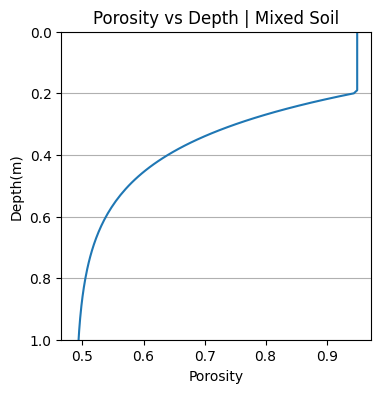

In [4]:
## plot figure-2

import numpy as np
import math


def rho_org(k,d_root,m_org,z):
    rho_org_value = (k*m_org*math.exp(-1*k*z))/(1-math.exp(-1*k*d_root))
    return rho_org_value

p = []
ff = []
z = np.arange(0,1.5,0.01)

for i in range(len(z)):

    f_org = rho_org(k,d_root,m_org,z[i])/rho_org_max
    if f_org >1:
        f_org = 1
    pv = (1-f_org)*p_min + f_org*p_org
    ff.append(f_org)
    p.append(pv)



import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))

plt.plot(p,z)
plt.xlabel('Porosity')
plt.ylabel('Depth(m)')
# plt.grid()
plt.gca().invert_yaxis()

plt.plot()

plt.ylim(1,0)

plt.title('Porosity vs Depth | Mixed Soil')
plt.gca().yaxis.grid(True)
plt.savefig('porosityvsdepth.png',dpi=300, format='png', bbox_inches='tight')
plt.show()


In [5]:
import numpy as np
from scipy.optimize import bisect
import math

def read_file4(filename):
    ## read tab-delimeated file xyz and returns x, y and z in list
    f = open(filename,'r')
    x = []
    y = []
    z = []
    r = []
    while True:
        line = f.readline().strip()
        if line=='':
            break
        raw = line.split('	')
        x.append(float(raw[0]))
        y.append(float(raw[1]))
        z.append(float(raw[2]))
        r.append(float(raw[3]))
    f.close()
    
    h = []
    for k in range(len(x)):
        h.append((x[k], y[k], z[k], r[k]))
           
    return x,y,z,r,h
        

## convert E to ALT
## read seasonal amplitude: E

ff = read_file4('E.dat')

# gives us AL
def al(z):
    return 0.04417012*z - 0.0225699527272727*np.exp(-5.5*z) + 0.0225699527272727 + ff[2][i]


w = []
for i in range(len(ff[2])): 
    if ff[2][i] >= 0: # it is set by trial and error due to reference point selection in InSAR process.
        z1=0
        w.append(z1)
    if ff[2][i] < 0: 
        z1 = bisect(al, 0, 4, xtol=1e-6) 
        w.append(z1)

# save ALT for eeach pixel into file
file_out = open('alt.dat','w') 
for i in range(len(w)):
    file_out.write('%s\t%s\t%.5f\n'%(ff[0][i],ff[1][i],w[i]))

file_out.close()
